# Single Bragg Pulse Dataset Matching

I recorded a single Bragg pulse dataset back in January. It fits well to my Bragg pulse model. This is an updated version of the analysis that uses the up to date `mwave` library.

The outline of this notebook is as follows:
1. The ARTIQ code used to set the two photon detuning is used to determine the two photon detuning in recoil frequencies.
2. The Bragg pulse profiles were recorded on a photodiode. These traces are examined to determine the relationship between the function generator voltage and the effective Rabi frequency.
3. The same Bragg pulse profiles are used to create a model of the effective Rabi frequency's time dependence, including the pedistal that the Bragg pulses sit on top of.
4. The model describing the single Bragg pulse is discussed:
    - Transverse cloud and beam spread
    - Cloud velocity spread
5. Finally the model is used to compute the expected single Bragg pulse behavior. This is compared to the experiment.

Note each section's code is independent of the other sections--you need not run all sections if you are only interested in the results from one of them.

### Matching experiment and simulation detuning

The following lines taken from ARTIQ show how the detuning between the two Bragg beam components are set in the experiment
```python
IFY_freq_bragg_offset_kHz 32.0
MOT_freq_dual_freq_MHz 180.0
h_over_m_factor 1

# Recoil frequency computed in linear frequency
self.model.wre_kHz = self.model.h_over_m_factor * 2.0*np.pi/1000.0 * self.model.hbar_Js / 2.0 / self.model.m_Cs_kg * (self.model.tisaph_freq_Hz / self.model.c_m_s)**2

# Computation of df_bragg_order
SCI_down = True
df_bragg_order = 2.0*self.model.IFY_n_bragg_order_num*self.model.wre_kHz*1000.0
if SCI_down == False:
    df_bragg_order = -df_bragg_order

# Setting of DDS
self.mot.dds_dual_frequency.set(self.model.MOT_freq_dual_freq_MHz*1000000.0-2.0*(self.model.IFY_freq_bragg_offset_kHz*1000.0 - df_bragg_order), amplitude = self.model.MOT_pwr_dual_freq_amplitude)
```
Lets walk through each non-trivial line here:

The variable `self.model.wre_kHz` is the linear recoil frequency computed for a laser blue detuned from the F=3$\to$F'=4 transition by 6675MHz. The expression for this quantity is equivalent to what I calculated in my Bragg diffraction notes
$$f_\text{recoil}=\frac{\pi\hbar f_\text{laser}^2}{mc^2}$$

The variable `df_bragg_order` is meant to represent the frequency difference needed between the two Bragg beam components to drive a particular Bragg order. It is defined incorrectly in ARTIQ. ARTIQ defines it as
$$f_\delta=2nf_\text{recoil}\qquad\text{incorrect!}$$
By deriving the Bragg diffraction condition you would find
$$f_\delta=\omega_1-\omega_2=4(n_0+n_f)f_\text{recoil}$$
So ARTIQ is missing a factor of two. This is compensated for in the next line where the DDS is actually set.

The dual frequency DDS which drives the AOM responsible for generating the diffraction arm beam (as opposed to the gravity ramp beam) is set to the following frequency in the ARTIQ code
```python
self.model.MOT_freq_dual_freq_MHz*1000000.0-2.0*(self.model.IFY_freq_bragg_offset_kHz*1000.0 - df_bragg_order)
```
The first term brings the DDS to the center frequency of the AOM. The factor of $-2$ fixes the error caused previously by the incorrect definition of `df_bragg_order`. The line also provides an offset `IFY_freq_bragg_offset_kHz` which is used to account for frequency offsets caused by the Doppler shift of the atoms. We typically set `IFY_freq_bragg_offset_kHz=32`, which seems to bring the Bragg diffraction pulses into resonance. When we scan the Bragg two photon detuning in ARTIQ we are changing `IFY_freq_bragg_offset_kHz`.

Now that we have decoded what is going on in ARTIQ it is time to determine the exact conversion between a particular value of `IFY_freq_bragg_offset_kHz` and $f_\delta$ in units of the angular recoil frequency.

Let $f_\text{exp}$ represent the value of `IFY_freq_bragg_offset_kHz` used for a given RID in the [Bragg detuning scan dataset](https://www.notion.so/bragg-dataset-2-61bf64c820f6478d89da3b22e27c9509?pvs=4#235e07fb910e492eadabfc3e611f222b). `IFY_freq_bragg_offset_kHz=32` the Bragg pulses are resonant with first order Bragg, which means that $f_\text{exp}=32$ results in $f_\delta=4f_\text{recoil}$. So it must be that
$$f_\delta=4f_\text{recoil}+2*(32-f_\text{exp})\times1000$$
where the factor of 1000 converts the frequeny from kHz to Hz. Finally we convert units where $1=\omega_\text{recoil}$ via $\delta=2\pi f_\delta/\omega_\text{recoil}$.

In [ ]:
import numpy as np

hbar = 1.05457e-34 # J*s
m_Cs = 2.20694650e-25 # kg
c = 2.99792458e8 # m/s
f_laser = 351.72571850e12 + 5.170855370625e9 + 12.815e6 + 6675e6 # Hz
f_recoil = np.pi*hbar*(f_laser)**2/(m_Cs*(c**2))
omega_recoil = 2*np.pi*f_recoil
delta_conversion_fnc = lambda f_exp: (4*f_recoil + 2*(32 - f_exp)*1000)/f_recoil

Or written out without all of this calculation

In [ ]:
delta_conversion_fnc = lambda f_exp: 4+2*(32 - f_exp)*1000/2066.4724020963313

In the above dataset the detuning is defined as the negative of this.

### Matching Bragg amplitude to experiment

Via the scope trace dataset I took [here](https://www.notion.so/bragg-dataset-2-61bf64c820f6478d89da3b22e27c9509?pvs=4#cc665d63d1254f8d8abe8e9758424d09) I can relate the function generator Bragg amplitude to the pit photodiode voltage. Using [my measurements of the beam power before the chamber and the photodiode voltage](https://www.notion.so/Interferometry-beam-power-calibration-1d9a2d697f25470d94367df9b40caffc?pvs=4) I can determine the relationship between the pit photodiode voltage and the beam intensity (since I also know the beam size). By computing the effective Rabi frequency from the beam intensity I can relate the pit photodiode voltage to the beam intensity. Putting this all togeather will relate the function generator amplitude to the Rabi frequency.

#### Relating function generator amplitude to beam power

First lets load and plot a trace

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import h5py

with h5py.File('single_bragg_dataset.h5', 'r') as f:
    xdata = f['bragg_averaged_with_pulse_traces/scope_t'][()]
    ydata = f['bragg_averaged_with_pulse_traces/scope_trace'][()]
    amps = f['bragg_averaged_with_pulse_traces/bragg_amplitudes_mV'][()]*1000

x = xdata[0,0,0,:]
y = ydata[0,0,0,:]

plt.plot(x,y)
plt.xlabel('time [s]')
plt.ylabel('photodiode voltage [V]')
plt.show()

Now lets try fitting this trace

In [ ]:
from scipy.optimize import curve_fit

# Define fit function
def gauss_trunc(t, amp, sig, tau, t0, baseline, offset):
    y = amp*np.exp(-np.square(t-t0)/(2*(sig**2))) + offset
    y[np.abs(t - t0) > tau] = baseline
    return y

# Perform fit
p0 = [0.3, 40e-6, 5*40e-6, np.mean(x), -0.02, 0.07]
popt, pcov = curve_fit(gauss_trunc, x, y, p0)

# Plot
plt.plot(x, y, label='data')
plt.plot(x, gauss_trunc(x, *p0), label='guess')
plt.plot(x, gauss_trunc(x, *popt), label='fit')
plt.xlabel('time [s]')
plt.ylabel('photodiode voltage [V]')
plt.legend()
plt.show()

print(popt)

First of all, it looks like the Gaussian isn't truncated how I expected from ARTIQ. Second of all there is a pretty large pedistal at low powers. This might have an effect at lower Bragg amplitudes.

Now lets fit all of the measured scope traces.

In [ ]:
measured_amp_V = []
measured_offset_V = []

for i in range(len(amps)):

    # Get data for this amplitude
    x = xdata[i,0,0,:]
    y = ydata[i,0,0,:]
    
    # Perform fit
    p0 = [0.3, 40e-6, 5*40e-6, np.mean(x), -0.02, 0.07]
    popt, pcov = curve_fit(gauss_trunc, x, y, p0)

    # Save fit offset and amplitude
    measured_amp_V.append(popt[0])
    measured_offset_V.append(popt[5])

measured_amp_V = np.array(measured_amp_V)
measured_offset_V = np.array(measured_offset_V)

Now lets fit the relationship between the maximum measured photodiode amplitude in volts (including the offset) and the function generator amplitude.

In [ ]:
from scipy.stats import linregress

# Perform linear regression
res = linregress(amps, measured_amp_V+measured_offset_V)

# Plot
plt.plot(amps, measured_amp_V + measured_offset_V, label='data')
plt.plot(amps, res.intercept + res.slope*amps, label='fit')
plt.xlabel('function generator voltage [mV]')
plt.ylabel('voltage on photodiode at gaussian peak [V]')
plt.legend()
plt.show()

# Print result
print('y=mx+b\nm=%0.3e V [photodiode]/mV [func gen]\nb=%0.3e V [photodiode]' % (res.slope, res.intercept))

#### Relating beam power to photodiode voltage
In [this lab note](https://www.notion.so/Interferometry-beam-power-calibration-1d9a2d697f25470d94367df9b40caffc?pvs=4) I recorded that the photodiode voltage is related to beam power $P$ via 46.38mW/V.

#### Relating $I$ to $\Omega$

Next lets relate the local intensity $I$ to the Rabi frequency $\Omega$. Here I am using code from `aisim/raman_transition_magic_wavelength.nb` to compute the relationship between $I$ and $\Omega$:

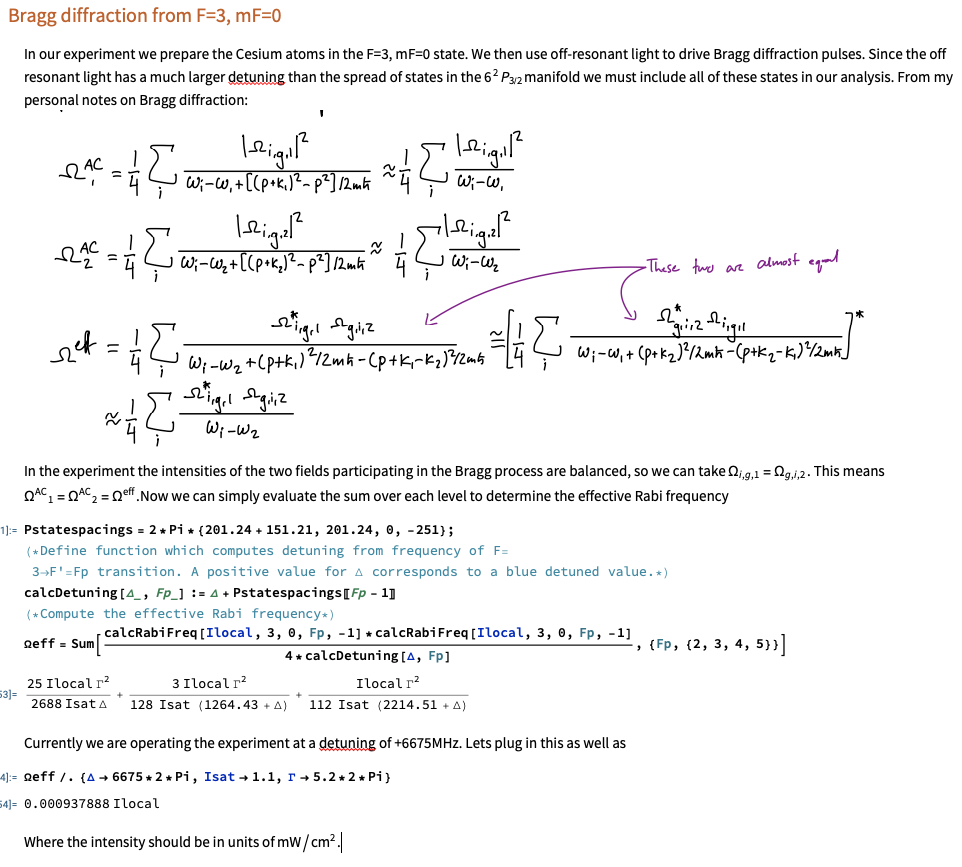

Great, we see $\Omega=0.000937888I$, where $I$ is measured in mW/cm$^2$ and $\Omega$ is measured in Megahertz.

#### Relating beam power to $I$
First lets relate the pit photodiode voltage to the center beam intensity. The beam intensity has a Gaussian profile. Integrating over this profile gives us a power
$$P=\int_{-\infty}^\infty\int_{-\infty}^\infty I_0\exp\left(-2\frac{x^2+y^2}{w_0^2}\right)\mathrm{d}x=\pi I_0w_0^2/2$$

#### Putting this all togeather

Let $V_p$ be the photodiode voltage in V and $V_f$ be the function generator voltage in mV. [Above](#Relating-function-generator-amplitude-to-beam-power) we found that
$$V_p=4.7\times10^{-2} + 5.3\times10^{-3}V_f$$

We know from [here](#Relating-beam-power-to-photodiode-voltage) that the photodiode voltage is related to beam power via $P=46.38V_p$, where $P$ is in mW. We also found that $I_0=2P/\pi w_0^2$

Finally we can relate the central beam intensity to the Rabi frequency in MHz via $\Omega^\mathrm{eff}_0=0.000937888I_0$.

Plugging these all in we find
$$\Omega^\mathrm{eff}_0=\frac{0.00130155}{w_0^2} + \frac{0.00014677 V_f}{w_0^2}$$
where $w_0$ is in cm. For the collimator we currently use $w_0=0.767$cm. So
$$\Omega^\mathrm{eff}_0=0.00221243+0.000249486V_f$$
Converting $\Omega^\mathrm{eff}_0$ into units of $\omega_\mathrm{r}$ we find
$$\Omega^\mathrm{eff}_0=0.170435+0.0192192V_f$$

How does this match up to the experiment? In section [Comparison of Bragg power, detuning scan with simulation comparison 2](#Experiment-and-simulation-comparison-2) I perform the following conversion on the function generator amplitudes to get the experimental data to line up with the simulated data
```python
# Align bragg amplitude
bragg_amplitudes_aligned = (bragg_amplitudes + 6)/26
```
Note that
$$1/26\approx0.0384\approx2\times0.0192192$$
$$6/26=0.231=2\times0.115$$
So aside from what seems to be a factor of two error somewhere, my calcuation seems to agree well with what I found from my manual fit attempt.

### Modeling the Bragg pulse profile in time

Above we saw that there is a large pedistal on the Bragg pulse. We need to include this pedistal in the model to replicate our experimental data. To do this I will make a model that can describe the pulses recorded by the pit photodiode.

In [ ]:
# Define fit function
def gauss_trunc(t, amp, sig, tstart, tend, t0, baseline, offset):
    y = amp*np.exp(-np.square(t-t0)/(2*(sig**2))) + offset
    y[t < tstart] = baseline
    y[t > tend] = baseline
    return y

# Perform fit
p0 = [0.3, 40e-6, 0.12888, 0.1293, np.mean(x), -0.02, 0.07]
popt, pcov = curve_fit(gauss_trunc, x, y, p0, method='trf')

# Plot
plt.plot(x, y, label='data')
plt.plot(x, gauss_trunc(x, *p0), label='guess')
plt.plot(x, gauss_trunc(x, *popt), label='fit')
plt.legend()
plt.xlabel('time [s]')
plt.ylabel('photodiode voltage [V]')
plt.show()

For some reason this isn't fitting the pedistal start and end times. Let me sweep over those and see which one has the lowest sum of residuals

In [ ]:
fnc = lambda *x: gauss_trunc(x[0], popt[0], popt[1], x[1], x[2], popt[4], popt[5], popt[6])

# Compute residuals scanning tstart, remember tstart that results in smallest residual
tstarts = np.linspace(0.1288, 0.1289)
min_resid = np.sum(np.abs(y - fnc(x, tstarts[0], 0.1293)))
min_resid_idx = 0
for i in range(len(tstarts)):

    resid = np.sum(np.abs(y - fnc(x, tstarts[i], 0.1293)))
    if resid < min_resid:
        min_resid = resid
        min_resid_idx = i

print("Best value for tstart is %0.5f" % tstarts[min_resid_idx])
tstart = tstarts[min_resid_idx]

# Do the same but for tend
tends = np.linspace(0.12925, 0.12935)
min_resid = np.sum(np.abs(y - fnc(x, tstart, tends[0])))
min_resid_idx = 0
for i in range(len(tends)):

    resid = np.sum(np.abs(y - fnc(x, tstart, tends[i])))
    if resid < min_resid:
        min_resid = resid
        min_resid_idx = i

print("Best value for tend is %0.5f" % tends[min_resid_idx])
tend = tends[min_resid_idx]

Now lets fit the trace again

In [ ]:
# Define fit function
def gauss_trunc(t, amp, sig, t0, baseline, offset):
    tstart, tend = 0.12889, 0.12930
    y = amp*np.exp(-np.square(t-t0)/(2*(sig**2))) + offset
    y[t < tstart] = baseline
    y[t > tend] = baseline
    return y

# Perform fit
p0 = [0.3, 40e-6, np.mean(x), -0.02, 0.07]
popt, pcov = curve_fit(gauss_trunc, x, y, p0)

# Plot
plt.plot(x, y, label='data')
plt.plot(x, gauss_trunc(x, *p0), label='guess')
plt.plot(x, gauss_trunc(x, *popt), label='fit')
plt.legend()
plt.xlabel('time [s]')
plt.ylabel('photodiode voltage [V]')
plt.show()

That looks good. Lets scan this over all recorded photodiode traces and see how the model holds up.

In [ ]:
import ipywidgets as widgets

%matplotlib widget

# Set up plot
plt.figure()
ldata, = plt.plot(x, y, label='data')
lfit, = plt.plot(x, gauss_trunc(x, *popt), label='fit')
plt.legend()
plt.xlabel('time [s]')
plt.ylabel('photodiode voltage [V]')

# Create update function
def update(i):

    # Extract dataset
    y = ydata[i, 0, 0, :]

    # Set raw data
    ldata.set_ydata(y)

    # Fit
    p0 = [0.3, 40e-6, np.mean(x), -0.02, 0.07]
    popt, pcov = curve_fit(gauss_trunc, x, y, p0)

    # Set fit plot
    lfit.set_ydata(gauss_trunc(x, *popt))

    # Set yaxis limits
    plt.ylim([np.min(y), np.max(y)])

    # Update title
    plt.title('offset-baseline=pedestal=%0.5f\nt0=%0.5f' % (popt[4]-popt[3], popt[2]))

# Make interactive
widgets.interact(update, i=widgets.IntSlider(min=0, max=ydata.shape[0]-1))

plt.show()

%matplotlib inline

The model seems to work well and the pedestal height is roughly constant. The central time is consistently 0.12910. I am going to average across all pedestal heights and take the average to be the official pedestal height.

In [ ]:
pedestal_heights = []
for i in range(len(amps)):

    # Extract dataset
    y = ydata[i, 0, 0, :]

    # Fit and save pedestal height
    p0 = [0.3, 40e-6, np.mean(x), -0.02, 0.07]
    popt, pcov = curve_fit(gauss_trunc, x, y, p0)
    pedestal_heights.append(popt[4]-popt[3])

# Average across all heights
print('mean pedestal (offset-baseline) height = %0.5f' % np.mean(np.array(pedestal_heights)))

Lets convert this into a Rabi frequency using our result from [an earlier section](#Relating-beam-power-to-photodiode-voltage). There we ultimated related the function generator voltage to the Rabi frequency. Here I want to relate a photodiode voltage to a Rabi frequency, so I will need to combine a few of the results from that section in a different way:

Relationship between beam power $P$ in mW and photodiode voltage in V: $P=46.38V_p$

Relationship between central beam intensity and beam power: $I_0=2P/\pi w_0^2$

Relationship between effective Rabi frequency in MHz and intensity in mW/cm^2: $\Omega^\mathrm{eff}_0=0.000937888I_0$.

Putting all of these togeather we find the Rabi frequency in recoil frequencies is related to the photodiode voltage in V via $\Omega^\mathrm{eff}_0=3.62628 V_p$

In [section](#Relating-beam-power-to-photodiode-voltage) I had found a factor of two disagreement when comparing to the experiment. Assuming that I missed this factor of two somewhere, the effective Rabi frequency should be related to photodiode voltage via $\Omega^\mathrm{eff}_0=2\times3.62628 V_p=7.25256 V_p$. **Therefore I am estimating the pedistal height produces an effective Rabi frequency pedestal of $\Omega^\mathrm{eff}_0=7.25256\times0.08190=0.5940$.**

Note that it is important I get this initial value for the pedestal height right as it will make the precompute tables much more expensive to generate. Scanning over the pedestal height as well as the effective Rabi frequency means adding another dimension to the precompute table scan.

The final thing to do now is to convert the model of the Gaussian into the units used in the simulation, namely t0, tstart, and tend:

In [ ]:
t0 = 0.12910
print("t0-tstart=%0.5f in recoil units" % ((t0 - tstart)*2*np.pi*2066))
print("tend-t0=%0.5f in recoil units" % ((tend - t0)*2*np.pi*2066))

## Model

The model consists of solving the Bragg Hamiltonian with a transverse position spread and a slight pedistal that comes from the imperfect operation of the pulse-shaper. Here I will describe how these effects are incorporated into the model. I will also describe how to think about the velocity spread of the atoms, although this is omitted from the model.

### Multi Atom Simulation: Velocity spread

Lets try accounting for the vertical velocity spread of the atoms in the cloud. I will do this by simulating the Bragg pulse over a range of initial velocities and then weighing those velocities by the proportion of that velocity class in the cloud at the start of the Bragg pulse.

First lets recall how the detuning is defined for the system that the `gbragg` function solves
$$\delta=\omega_1-\omega_2$$
To get a resonant Bragg process we must set
$$\delta=4\omega_\text{r}(n_0+n_\text{f})$$
where $n_0$ and $n_\text{f}$ describe the Bragg order, i.e. $n=1$ would describe a process where $2\hbar k$ photons are transferred. This condition comes from the Bragg diffraction derivation.

Now lets figure out how the Doppler shift will modify $\delta$. Recall $\omega'=\omega-kv=\omega-\omega v/c=\omega(1-v/c)$, so
$$\delta'=\omega_1'-\omega_2'=\omega_1(1-v/c)-\omega_2(1+v/c)=\delta-\omega_1v/c-\omega_2v/c=\delta-(\omega_1+\omega_2)v/c\approx\delta-2v\omega/c$$
We define all frequencies in terms of the recoil frequency, so
$$\delta'/\omega_\text{r}\approx\delta/\omega_\text{r}-2v\omega/\omega_\text{r}c=\delta/\omega_\text{r}-2v\frac{\omega}{c}\frac{2m}{\hbar k^2}=\delta/\omega_\text{r}-2v\frac{2m}{\hbar k}=\delta/\omega_\text{r}-4v/v_\text{r}$$

If we want to plug in a velocity in m/s then
$$\delta'\approx\delta-2v(2\pi\times351.7257185)/299792458=\delta-2v\times7.37163\times10^6$$
We are defining all our frequencies in terms of the recoil frequency, so we need to divide this final term by a recoil frequency
$$\delta'\approx\delta-2v\times7.37163\times10^6/(2\pi\times2066)=\delta-2v\times567.875$$ 

In [ ]:
from mwave.integrate import make_kvec, make_phi, gbragg
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

# Create vectorized gbragg function call
def vgbragg(kvec, omega, sigma, tfinal, delta, v_offset=0):
    out = np.full((len(omega), len(kvec)), np.nan, dtype=np.complex128)
    phi0 = make_phi(kvec, n0)

    for i in range(len(omega)):
        sol = gbragg(kvec, phi0, tfinal, delta - 4*v_offset, omega[i], sigma)
        out[i,:] = sol.y[:,-1]

    return out

# Create function to compute bragg pulse across velocity spread
def vdist(kvec, omega, sigma, tfinal, delta, v_sigma, v0, vs):

    # Create an array to store outputs in
    phi = np.full((len(vs), len(omega), len(kvec)), np.nan, dtype=np.complex128)
    
    # Loop over vs
    for i in tqdm(range(len(vs))):
        phi[i,:,:] = vgbragg(kvec, omega, sigma, tfinal, delta, v_offset=vs[i])

    # Calculate populations
    pops = np.abs(phi)**2

    # Calculate velocity weights
    weights = np.exp(-np.square(vs - v0)/(2*v_sigma**2))/v_sigma/np.sqrt(2*np.pi)

    # Weight populations and sum
    weighted_pops = np.einsum('ijk,i->jk', pops, weights, optimize=True)
    
    # Return
    return weighted_pops, pops, weights

# Set parameters
n0, nf = 0, -1
sigma = 40e-6*2066*2*np.pi
tfinal = 10*sigma

# Set velocity distribution
v0 = 0
v_sigma = 0.3
vs = np.linspace(-1,1,50)

# Compute kvec and sbragg_orders
kvec, n0_idx, nf_idx = make_kvec(n0,nf)
orders = kvec/2

# Compute population
omega_effs = np.linspace(0,60)
pops, _, _ = vdist(kvec, omega_effs, sigma, tfinal, 4*(n0+nf), v_sigma, v0, vs)

# Plot
plt.figure(figsize=(8.5, 4))
plt.plot(omega_effs, pops)
plt.legend(["n=%i" % bo for bo in orders])
plt.xlabel("Bragg amplitude [arb.]")
plt.ylabel("Population")
plt.show()

### Multi Atom Simulation: Transverse spatial spread

Lets try accounting for the transverse spatial spread of the cloud. I think this is a bit more promising than our previous attempt because we know that there is a spatial spread of atoms but we have little evidence for a large velocity spread. I will do this by simulating the Bragg pulse over a range of intensities and then weighing the Bragg process by the intensities sampled by different atoms in the cloud.

The effective Rabi frequency is given by
$$\Omega_\text{eff}=\frac{\Omega_1\Omega_2}{\Delta}\propto I^2$$
since $\Omega\propto I^2$. The intensity of the laser beam is approximately given by
$$I\propto\exp\left(-2\frac{x^2+y^2}{w_0^2}\right)$$
here $w_0$ is the $1/e^2$ radius. In our experiment $w_0\approx5\text{ mm}$. So
$$\Omega_\text{eff}(x,y)\propto\exp\left(-4\frac{x^2+y^2}{w_0^2}\right)$$

We will model the atoms as being spatially distributed in a Gaussian
$$N(x,y)=\frac{N_0}{\sigma\sqrt{2\pi}}\exp\left(-\frac{x^2+y^2}{2\sigma^2}\right)$$
For now I will make a big oversimplification for getting an order of magnitude estimate of $\sigma$ and assume that at the time of launch the atoms are all consolidated in a single point. After launch they spread out on average at the recoil velocity until the first Bragg pulse. So I will estimate $\sigma$ as
$$\sigma=t_\text{first bragg}v_\text{r}=0.207\text{ s}\times3.5\text{ mm/s}=0.0007245\text{ m}$$
Actually this seems a little small given that the MOT is probably around a mm in width. So lets be prepared to increase sigma if necessary. Lets compute the population in each output port as a function of effective Rabi frequency.

#### Aside: Investigating ratio of cloud to beam size

I'm curious if the absolute cloud size and beam size matter, or only their ratio. Based on a quick calculation I think it must only be the ratio that matters:

Let $\vec{f}(\Omega(\vec{x}))$ be a vector whose elements describe the population in each $k$ state after a Bragg pulse with spatially dependent Rabi frequency $\Omega(\vec{x})$. Define $N(\vec{x})$ as the number of atoms located at position $\vec{x}$ of the cloud. So the average population $\vec{f}_\mathrm{avg}$ transfer is given by
$$\vec{f}_\mathrm{avg}=\int_{-\infty}^\infty\vec{f}(\Omega(\vec{x}))N(\vec{x})/\int_{-\infty}^\infty N(\vec{x})$$
If $\Omega(\vec{x})\propto\exp\left(-2\frac{x^2+y^2}{\sigma_b^2}\right)$ and $N(\vec{x})\propto\exp\left(-\frac{x^2+y^2}{2\sigma_c^2}\right)$ then we see by expanding $\vec{f}$ that
$$\vec{f}(\Omega(\vec{x}))N(\vec{x})=(\dots)\Omega(\vec{x})^0N(\vec{x})+(\dots)\Omega(\vec{x})^1N(\vec{x})+(\dots)\Omega(\vec{x})^2N(\vec{x})+\cdots$$
Each of the $\Omega(\vec{x})^nN(\vec{x})$ terms can be expanded to
$$\Omega(\vec{x})^nN(\vec{x})\propto\exp\left(-2n\frac{x^2+y^2}{\sigma_b^2}\right)\exp\left(-\frac{x^2+y^2}{2\sigma_c^2}\right)=\exp\left(\left[x^2+y^2\right]\left[-2n\frac{1}{\sigma_b^2}-\frac{1}{2\sigma_c^2}\right]\right)$$
If we define $x=\tilde{x}\sigma_b$ and $y=\tilde{y}\sigma_b$ then we find
$$\Omega(\vec{x})^nN(\vec{x})\propto\exp\left(-\left[\tilde{x}^2+\tilde{y}^2\right]\left[2n+\frac{\sigma_b^2}{2\sigma_c^2}\right]\right)$$
Which is only dependent on the ratio of the two widths.

In [ ]:
from mwave.integrate import make_kvec, make_phi, gbragg
import numpy as np
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
from tqdm import tqdm

# Create vectorized gbragg function call
def vgbragg(kvec, omega, sigma, tfinal, delta, v_offset=0):
    out = np.full((len(omega), len(kvec)), np.nan, dtype=np.complex128)
    phi0 = make_phi(kvec, n0)

    for i in tqdm(range(len(omega))):
        sol = gbragg(kvec, phi0, tfinal, delta - 4*v_offset, omega[i], sigma)
        out[i,:] = sol.y[:,-1]

    return out

# Set parameters
n0, nf = 0, -1
sigma = 40e-6*2066*2*np.pi
tfinal = 10*sigma

# Set range of omegas
omegas = np.linspace(0,60,200)

# Compute kvec and sbragg_orders
kvec, n0_idx, nf_idx = make_kvec(n0,nf)
orders = kvec/2

# Call vgbragg over some intensity range, make interpolation function
phi = vgbragg(kvec, omegas, sigma, tfinal, 4*(n0+nf))
pfnc = interp1d(omegas, phi.T)

In [ ]:
sig = 0.7e-3
w0 = 5e-3

lim = 10*max(sig,w0)
dx = min(sig,w0)/10
x = np.arange(int(2*lim//dx))*dx - lim
X, Y = np.meshgrid(x,x)

I_grid = np.exp(-4*(X**2 + Y**2)/(w0**2))
N_grid = np.exp(-(X**2 + Y**2)/(2*sig**2))/(2*np.pi*sig**2)

def cpop(Omega0):
    phis = pfnc(I_grid*Omega0)
    pops = np.abs(phis)**2
    wpops = np.multiply(N_grid, pops)*dx*dx
    wpopssum = np.einsum('ijk->i', wpops)
    return wpopssum

In [ ]:
omegas2 = np.linspace(0,40)

pops = np.full((len(kvec), len(omegas2)), np.nan)
for i in tqdm(range(len(omegas2))):
    pops[:,i] = cpop(omegas2[i])

In [ ]:
# Plot
plt.figure(figsize=(8.5, 4))
plt.plot(omegas2, pops.T)
plt.legend(["n=%i" % bo for bo in orders])
plt.xlabel("Bragg amplitude [arb.]")
plt.ylabel("Population")
plt.show()

## Comparison of model to dataset

Now we are ready to compare our model to the actual dataset. First lets load in the dataset.

In [1]:
from mwave.integrate import bloch, make_kvec, make_phi, phase_fnc_constant
from mwave.interpolation import convergend
import numpy as np
import h5py
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
from tqdm import tqdm
from numba import jit

with h5py.File('single_bragg_dataset.h5') as f:
    bragg_amplitudes = np.array(f['bragg_detuning_dataset/bragg_amplitudes'][()])
    bragg_offsets_kHz = np.array(f['bragg_detuning_dataset/bragg_offsets_kHz'][()])
    bragg_orders = np.array(f['bragg_detuning_dataset/bragg_orders'][()])
    bragg_widths_us = np.array(f['bragg_detuning_dataset/bragg_widths_us'][()])
    fit_traces = np.array(f['bragg_detuning_dataset/fit_traces'][()])
    bragg_pops = np.array(f['bragg_detuning_dataset/pops'][()])
    raw_traces = np.array(f['bragg_detuning_dataset/raw_traces'][()])
    t = np.array(f['bragg_detuning_dataset/t'][()])

C:\Users\jack\AppData\Local\Temp\ipykernel_11488\3374551915.py:2: DeprecationWarning: the interpolation module is deprecated
  from mwave.interpolation import convergend


Lets express all relevant experimental parameters in natural units.

In [2]:
bragg_amplitudes_natural = (bragg_amplitudes + 3)/27
bragg_offsets_natural = 4+2*(32 - bragg_offsets_kHz)*1000/2066.4724020963313
bragg_sigmas_natural = bragg_widths_us/1e6*2066*2*np.pi

We must incorporate a pedistal into our model. Lets do this.

In [5]:
# Choose sigma and offset
offset_idx = 22
sigma_idx = 0

# Define sim parameters
sigma = bragg_sigmas_natural[sigma_idx]
pedistal = 0.59
n0 = 0
nmax = -7

# Compute parameters
t0 = 2.59621
tfinal = t0+1.94716

# Define the kvec array
kvec, n0_idx, nf_idx = make_kvec(n0, nmax)

# Define a constant pulse profile
@jit(nopython=True)
def omega_fnc(t, args):
    omega, sigma, t0, pedistal = args
    return omega*np.exp(-np.square(t-t0)/(2*(sigma**2))) + pedistal

def calc(delta, omega):
    # Define the initial state
    phi0 = make_phi(kvec, n0)
    
    # Integrate the pulse
    sol = bloch(kvec, phi0, tfinal, delta, omega_fnc, np.array([omega, sigma, t0, pedistal]), phase_fnc_constant, np.array([]), atol=1e-4, rtol=1e-4)

    return sol.y[:,-1]

It speeds things up to interpolate! Lets do this:

In [ ]:
# Define a grid
pvals = np.linspace(0,62,10)
dvals = np.arange(-6, -2).astype(float)

# Define interpolation function
def fnc(args):
    omega, delta = args
    out = np.empty((len(omega), len(delta), len(kvec)), dtype=np.complex128)
    for i in range(len(omega)):
        for j in range(len(delta)):
            out[i,j,:] = calc(delta[j], omega[i])
    return out

# Use converge1d to create an accurate interpolator for the function
xgrid, ygrid, ifnc = convergend(fnc, (pvals, dvals), verbosity=2, atol=5e-3, rtol=10)

C:\Users\jack\miniconda3\envs\lab\Lib\site-packages\scipy\integrate\_ivp\rk.py:521: RuntimeWarning: invalid value encountered in divide
  err5 = np.dot(K.T, self.E5) / scale
C:\Users\jack\miniconda3\envs\lab\Lib\site-packages\scipy\integrate\_ivp\rk.py:522: RuntimeWarning: invalid value encountered in divide
  err3 = np.dot(K.T, self.E3) / scale


In the future this spline interpolator could be used to create a denser set of points that can be linearly interpolated between. This will create a large speed up.

For now lets just do linear interpolation on a 1D cut of our converged grid.

In [ ]:
from scipy.interpolate import interp1d

# Make interpolator
# Index 32 is where delta=4
iifnc = interp1d(xgrid[0], np.abs(ygrid[:,32,:].T)**2)

# Set cloud parameters
sig = 0.75e-3
w0 = 5e-3

# Compute cloud/beam grids
lim = 10*max(sig,w0)
dx = min(sig,w0)/10
x = np.arange(int(2*lim//dx))*dx - lim
X, Y = np.meshgrid(x,x)

I_grid = np.exp(-4*(X**2 + Y**2)/(w0**2))
N_grid = np.exp(-(X**2 + Y**2)/(2*sig**2))/(2*np.pi*sig**2)

# Define function to create population weighted sum of population after pulse
def cpop(Omega0):
    pops = iifnc(I_grid*Omega0)
    wpops = np.multiply(N_grid, pops)*dx*dx
    wpopssum = np.einsum('ijk->i', wpops)
    return wpopssum

# Compute
pops = np.full((len(kvec), len(bragg_amplitudes_natural)), np.nan)
for i in tqdm(range(len(bragg_amplitudes_natural))):
    pops[:,i] = cpop(bragg_amplitudes_natural[i])

In [ ]:
# Plot
istart = np.argmin(np.abs(kvec - np.min(bragg_orders*2)))
iend = np.argmin(np.abs(kvec - np.max(bragg_orders*2)))

plt.figure(figsize=(10,6))
ls = plt.plot(bragg_amplitudes_natural, bragg_pops[:, 22, sigma_idx, :], 'x')
ls2 = plt.plot(bragg_amplitudes_natural, pops.T[:,istart:iend+1])

for i in range(len(ls)):
    ls2[i].set_color(ls[i].get_color())

plt.xlim([0,40])

plt.legend(["n=%i" % bo for bo in bragg_orders])
plt.xlabel("Bragg amplitude [arb.]")
plt.ylabel("Population")
plt.show()